# Markov Modelling
The following notebook uses markov modelling to determine transition probabilities for segments within calls, depending on the immediately preceding segment. See Sainburg et al., (2020) and github.com/timsainb/avgn for further detail on this process.

This notebook uses Python v3.8.13 (compared to v3.6 used in earlier notebooks), in order to use a more recent version of NetworkX which allows for self-loops.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import pandas as pd

In [2]:
import avgn

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR
from avgn.visualization.spectrogram import draw_spec_set
from avgn.utils.general import save_fig

In [4]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [5]:
DATASET_ID = "git_repos_call"

In [6]:
DT_ID = '2022-03-12_17-46-00'

## Call Dataframe

In [7]:
call_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'call_umap_grouped.pickle')
call_df[:3]

,start_time,end_time,labels,indv,indvi,filename,group,location,sex,wav_loc,...,comb_labels,umap,spectrogram,call_lab_simp,combi_lab_simp,call_unique_num,call_pos_combi,combi_label,combi_unique_num,simp
ID,,,,,,,,,,,,,,,,,,,,,
0,0.753604,0.921160,DSSHDS,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,DSSHDS,"[5.7770762, 7.997407]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH,0,0,DSSHDS SHSHLH,0,Other Calls
1,0.932017,1.367130,SHSHLH,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,SHSHLH,"[1.8122675, 5.094298]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS-SH-DS SH-LH,1,1,DSSHDS SHSHLH,0,Contains LH Segment
2,1.218085,1.308841,DS,MGGY,0,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,DS,"[9.353501, 10.055656]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS,DS SH-LH,2,0,DS USC,1,Other Calls


In [8]:
len(call_df)

561

## Combined UMAP & Transitions

In [12]:
import matplotlib.pyplot as plt
from avgn.visualization.barcodes import plot_sorted_barcodes, indv_barcode

### Plot barcodes for organization

In [13]:
call_df.sort_values(by=['simp'], inplace = True)

simp ['Contains LH Segment' 'NL Segment Alone' 'Other Calls']


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/8778 [00:00<?, ?it/s]

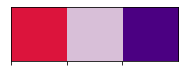

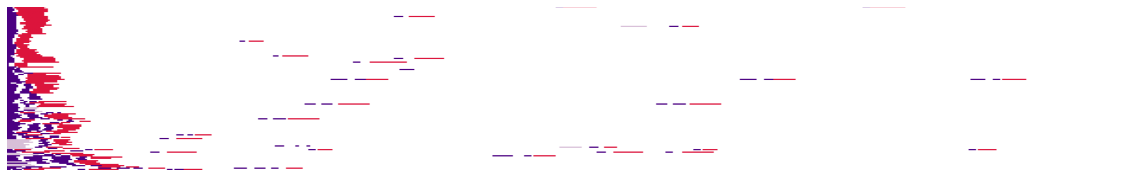

In [15]:
colors = ['crimson', 'thistle','indigo', 'plum']
all_dict = {}
for label in ["simp"]:
    print(label, call_df[label].unique())
    color_lists, trans_lists, label_pal_dict, label_pal, label_dict = indv_barcode(
        call_df,
        time_resolution=0.03,
        label="simp",
        pal=colors,
    )
    
    all_dict[label] = {
    "label_pal_dict": label_pal_dict,
    "label_dict": label_dict,
    }
    
    fig, ax = plt.subplots(figsize=(20, 3))

    plot_sorted_barcodes(
        color_lists,
        trans_lists,
        max_list_len=600,
        seq_len=100,
        nex=200,
        figsize=(10, 4),
        ax=ax,
    )
    plt.show()

In [16]:
call_df.sort_values(by=['ID'], inplace = True)

In [19]:
from avgn.visualization.projections import scatter_spec
from avgn.visualization.network_graph import plot_network_graph

In [22]:
call_df.columns

Index(['start_time', 'end_time', 'labels', 'indv', 'indvi', 'filename',
       'group', 'location', 'sex', 'wav_loc', 'key', 'rate', 'comb_labels',
       'umap', 'spectrogram', 'call_lab_simp', 'combi_lab_simp',
       'call_unique_num', 'call_pos_combi', 'combi_label', 'combi_unique_num',
       'simp'],
      dtype='object')

In [23]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [25]:
specs = list(call_df.spectrogram.values)
specs = [norm(i) for i in tqdm(specs)]

  0%|          | 0/561 [00:00<?, ?it/s]

In [ ]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(24)
ax1 = plt.subplot2grid(shape=(1, 24), loc=(0, 0), colspan=12)  ##1st Row
ax2 = plt.subplot2grid(shape=(1, 24), loc=(0, 12), colspan=12) #2nd row

colors = ['thistle', 'indigo', 'crimson']
#box = ax1.get_position()
#ax1.set_position([box.x0, box.y0, box.width * 1.1, box.height*1.1])
nex = -1
ax1.axis('off')
scatter_spec(
    np.array(list(call_df['umap'].values)),
    specs,
    column_size=10,
    x_range = [-1,11],
    y_range = [0,12],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    ax=ax1,
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': call_df.simp.values,
        'alpha':1,
        's': 15,
        'show_legend': False,
        "color_palette": colors,
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.5,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

for label in ["simp"]:
    print(label)
    # plot graph
    elements = call_df[label].values
    projections = np.array(list(call_df['umap'].values))
    sequence_ids = np.array(call_df["combi_unique_num"])

    label_pal_dict = all_dict[label]['label_pal_dict']
    label_dict = all_dict[label]['label_dict']

    pal_dict = {i:label_pal_dict[j] for i,j in label_dict.items()}
    ax2.axis('off')
    plot_network_graph(
        elements, projections, sequence_ids, color_palette="tab20", ax=ax2, pal_dict=pal_dict  
    )

  
    
ax1.set_title("A)", loc='left', fontsize = 25)
ax2.set_title("B)", loc='left', fontsize = 25)
# Shrink current axis by 20%
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width, box.height])
legend = ax2.legend(loc='upper left', labels = label_dict, bbox_to_anchor=(0, 1), fontsize=18, frameon=False)
handles = legend.legendHandles
# There are many more hatches available in matplotlib
colors = ['crimson', 'thistle','indigo', 'orchid']
for i, handle in enumerate(handles):
    handle.set_edgecolor(colors[i]) # set_edgecolors
    handle.set_facecolor(colors[i])
    #handle.set_alpha(0.7)

save_loc = (FIGURE_DIR / 'manuscript' / 'Figures' / 'Figure_4_050722_probabilities.jpeg')
ensure_dir(save_loc.as_posix())
save_fig(save_loc, dpi=600, save_jpg=False)
plt.show()